## EY Datawave Challenge Code

**Simple rule**: 
- all "df_xx" types are pd.DataFrame
- "xx_data" are usually NumPy arrays

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import normalize
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

pd.set_option('display.max_columns', None)

# Cool point got from here

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [2]:
# # fix random seed for reproducibility
# seed = 7
# np.random.seed(seed)

# Create a Callback

In [3]:
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') >= 0.9:
            print("Reached 90% acc so cancelling training!")
            self.model.stop_training = True

reach_90acc = MyCallback()

# Metric for F1

https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

In [4]:
class F1(keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

# Read the training Data

df is training data + label

In [5]:
#read training data
df_train = pd.read_csv("/Users/Godwithus/Desktop/EY/data_train.csv", low_memory=False) #nrows = integer
df_train = df_train.loc[:,'hash':'y_exit']
df_train.fillna('', inplace=True)

# Read the test Data

df_test is test data + label

In [6]:
#read test data
df_test = pd.read_csv("/Users/Godwithus/Desktop/EY/data_test.csv", low_memory=False)
df_test = df_test.loc[:,'hash':'y_exit']
df_test.fillna('', inplace=True)

## Some look at the data

In [7]:
#debugging
# print(df_test_pred)
# print(df_test_eval)

print (df_train.info())
print (df_test.info())

df_train.describe()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814262 entries, 0 to 814261
Data columns (total 11 columns):
hash             814262 non-null object
trajectory_id    814262 non-null object
time_entry       814262 non-null object
time_exit        814262 non-null object
vmax             814262 non-null object
vmin             814262 non-null object
vmean            814262 non-null object
x_entry          814262 non-null float64
y_entry          814262 non-null float64
x_exit           814262 non-null float64
y_exit           814262 non-null float64
dtypes: float64(4), object(7)
memory usage: 68.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202937 entries, 0 to 202936
Data columns (total 11 columns):
hash             202937 non-null object
trajectory_id    202937 non-null object
time_entry       202937 non-null object
time_exit        202937 non-null object
vmax             202937 non-null object
vmin             202937 non-null object
vmean            202937 non-null obj

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,,,,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,,,,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,,,,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,,,,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,,,,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07


# Prepare the Training Data

choose the features: 

*for rn, I cannot handle velocity since there are NaN.*

Change the time values into float, by dividing into minutes.

Finally, store train_data as NumPy arrays, and normalize them.

In [8]:
# 1. Prepare time stayed in the city hall (seconds)
df_train['time_entry_seconds'] = pd.to_timedelta(df_train['time_entry']).dt.total_seconds()
df_train['time_exit_seconds']=pd.to_timedelta(df_train['time_exit']).dt.total_seconds()
df_train['time_stayed_seconds']=df_train['time_exit_seconds']-df_train['time_entry_seconds']

df_train.head()

# 2. prepare whether entry point is in cityhall
x_in_city = (df_train['x_entry'] >=3750901.5068) & (df_train['x_entry']<=3770901.5068)
y_in_city = (df_train['y_entry'] >= -19268905.6133) & (df_train['y_entry'] <= -19208905.6133)

df_train['entry_inside'] = 1*(x_in_city & y_in_city)

train_data=df_train.loc[:,['time_stayed_seconds','entry_inside']].values

# 3. the distance from the entry point from the city hall's mid point

df_train['distance'] = ((3760901.5068 - df_train['x_entry']).pow(2) + (-19238905.6133 - df_train['y_entry']).pow(2)).pow(1/2)


#make a numpy array
train_data=df_train.loc[:,['time_stayed_seconds','entry_inside','distance']].values

train_data = normalize(train_data)

#debug
df_train.entry_inside.describe()
df_train.head()

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,time_entry_seconds,time_exit_seconds,time_stayed_seconds,entry_inside,distance
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,,,,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,25471.0,25712.0,241.0,0,145261.881023
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,,,,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,26434.0,26742.0,308.0,0,85266.551966
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,,,,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,28412.0,29005.0,593.0,0,56962.437581
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,,,,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,29870.0,31043.0,1173.0,0,55736.470981
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,,,,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,52689.0,52689.0,0.0,0,49342.931074


# prepare Train Labels

prepare the label for training:

x_exit and y_exit values have to be within certain range. Do each of the comparison and store the value as 0 or 1 in train_label NumPy array.

In [9]:
#prepare training label

target_x = (df_train['x_exit']>=3750901.5068) & (df_train['x_exit']<=3770901.5068)
target_y = (df_train['y_exit']>=-19268905.6133) & (df_train['y_exit']<=-19208905.6133)

train_label = 1*(target_x & target_y)

df_train['train_label'] = train_label


train_label = train_label.values

# train_label = to_categorical(train_label)

# Prepare the Test Data

choose the features: 

*velocty for pred data is weired

Change the time values into float, by dividing into minutes.

Finally, store test_data_pred and test_data_eval as NumPy arrays, and normalize them.

In [10]:
df_test['time_entry_seconds'] = pd.to_timedelta(df_test['time_entry']).dt.total_seconds()
df_test['time_exit_seconds']=pd.to_timedelta(df_test['time_exit']).dt.total_seconds()
df_test['time_stayed_seconds']=df_test['time_exit_seconds']-df_test['time_entry_seconds']

x_in_city = (df_test['x_entry'] >=3750901.5068) & (df_test['x_entry']<=3770901.5068)
y_in_city = (df_test['y_entry'] >= -19268905.6133) & (df_test['y_entry'] <= -19208905.6133)
df_test['entry_inside'] = 1*(x_in_city & y_in_city)

df_test['distance'] = ((3760901.5068 - df_train['x_entry']).pow(2) + (-19238905.6133 - df_train['y_entry']).pow(2)).pow(1/2)




# Divide Pred and Eval

In [11]:
df_test_pred = df_test[df_test['x_exit'] == ""]
df_test_eval = df_test[df_test['x_exit'] != ""]

# Prepare the features

In [12]:
test_data_pred = df_test_pred.loc[:,['time_stayed_seconds','entry_inside', 'distance']]
test_data_pred = test_data_pred.values
test_data_pred = normalize(test_data_pred)

test_data_eval = df_test_eval.loc[:,['time_stayed_seconds','entry_inside', 'distance']]
test_data_eval = test_data_eval.values
test_data_eval = normalize(test_data_eval)

# prepare Test Labels

prepare the label for test:

x_exit and y_exit values from df_test_eval (not pred). 0 or 1 in train_label NumPy array.

In [13]:
#prepare test label

target_x = (df_test_eval['x_exit']>=3750901.5068) & (df_test_eval['x_exit']<=3770901.5068)
target_y = (df_test_eval['y_exit']>=-19268905.6133) & (df_test_eval['y_exit']<=-19208905.6133)

test_label = 1*(target_x & target_y)

df_test_eval['test_label'] = test_label

test_label = test_label.values

df_test_eval.head()

/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,time_entry_seconds,time_exit_seconds,time_stayed_seconds,entry_inside,distance,test_label
0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_0,11:43:17,11:50:17,,,,3.773413e+06,-1.909828e+07,3.77311e+06,-1.91451e+07,42197.0,42617.0,420.0,0,145261.881023,0
1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,12:21:37,12:21:37,0,0,0,3.773199e+06,-1.914354e+07,3.7732e+06,-1.91435e+07,44497.0,44497.0,0.0,0,85266.551966,0
2,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_3,12:34:27,13:14:11,,,,3.763760e+06,-1.921342e+07,3.77176e+06,-1.91109e+07,45267.0,47651.0,2384.0,1,56962.437581,0
3,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_4,13:25:33,13:43:13,,,,3.773385e+06,-1.911344e+07,3.77313e+06,-1.91447e+07,48333.0,49393.0,1060.0,0,55736.470981,0
5,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_0,08:08:23,08:20:08,17.29,17.29,17.29,3.771380e+06,-1.933274e+07,3.76993e+06,-1.93409e+07,29303.0,30008.0,705.0,0,45797.982227,0


# Custom F1 loss function

In [14]:
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# define Keras NN model

binary softmax, but categorical_crossentropy loss. *can improve loss, optimizer, layer*

In [24]:
#train_data = train_data.reshape(814262, 7,1)
#define model
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

#complile the model
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) 

#fit the model
f1 = F1((test_data_eval, test_label))
history = model.fit(train_data, train_label, epochs=10, \
                    validation_data=(test_data_eval, test_label), callbacks=[reach_90acc, f1]) #, f1

Train on 814262 samples, validate on 169422 samples
Epoch 1/10
 98784/814262 [==>...........................] - ETA: 47s - loss: 0.5879 - acc: 0.7161

KeyboardInterrupt: 

# Evaluation of the Model

print the summary and test accuracy

In [16]:
#test_data_eval = test_data_eval.reshape(169422, 7, 1)

#evaluate the accuracy of the model
model.summary()

test_loss, test_acc = model.evaluate(test_data_eval, test_label)

print('Test accuracy:', test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  400       
_________________________________________________________________
dense_1 (Dense)              multiple                  10100     
_________________________________________________________________
dense_2 (Dense)              multiple                  101       
Total params: 10,601
Trainable params: 10,601
Non-trainable params: 0
_________________________________________________________________
169422/169422 [==============================] - 6s 34us/sample - loss: 0.3513 - acc: 0.8423
Test accuracy: 0.8423168


# Plot the model's Learning Curve

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


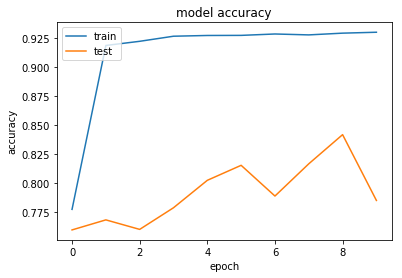

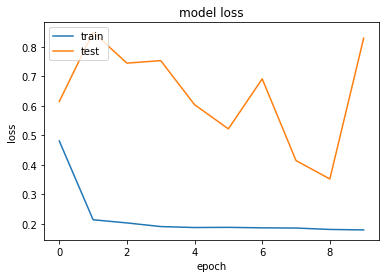

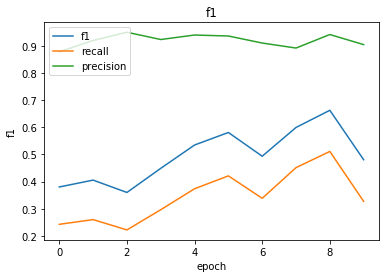

In [22]:
# summarize history for acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for f1, recall, precision
plt.plot(f1.val_f1s)
plt.plot(f1.val_recalls)
plt.plot(f1.val_precisions)
plt.title('f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1', 'recall','precision'], loc='upper left')
plt.show()

# Predict the Data

Predict the test_data_pred and if the p(xi) is over 0.5, save it as 1, otherwise 0. Predictions is the NumPy array saving the result. Formulate pd.DataFrame from df_testPred['trajectory_id'] and predictions ('target') so that the output DataFrame is in ['id', 'target'] format.

In [23]:
#test_data_pred = test_data_pred.reshape(33515, 7, 1)

#predict and handle output
predictions = model.predict(test_data_pred)

print(predictions)
predictions = (predictions >= 0.5) *1

id = pd.DataFrame(df_test_pred['trajectory_id'])

target = pd.DataFrame(predictions)
# target.columns = ['zeros','target']
# target = target['target']
target.columns = ['target']

output = pd.concat([id.reset_index(drop=True),target.reset_index(drop=True)], axis=1)
output.columns = ['id', 'target']
output.to_csv("/Users/Godwithus/Desktop/EY/try_1.csv", index=False)

[[0.07107535]
 [0.01540992]
 [0.00155845]
 ...
 [0.00079814]
 [0.03029984]
 [0.00079814]]


In [19]:
#debugging
print("test_data_pred", test_data_pred.shape)
print("predictions", predictions.shape)
print("df_test_pred", df_test_pred.shape)
print("id", id.shape)
print("target", target.shape)
print("output", output.shape)

print(output)

print(target.sum()/np.size(target, 0))

test_data_pred (33515, 3)
predictions (33515, 1)
df_test_pred (33515, 16)
id (33515, 1)
target (33515, 1)
output (33515, 2)
                                                id  target
0       traj_00032f51796fd5437b238e3a9823d13d_31_5       0
1      traj_000479418b5561ab694a2870cc04fd43_25_10       0
2       traj_000506a39775e5bca661ac80e3f466eb_29_5       0
3        traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4       0
4        traj_00063a4f6c12e1e4de7d876580620667_3_4       0
5       traj_0006535be25bb52dd06983447880c964_5_12       0
6       traj_0006f84bb33ec929d1cda7686f861d0a_31_3       1
7      traj_00093ae562586aed0e053b8431e8ace4_23_10       0
8       traj_000c739e444a70e1804d757a0580caaa_31_3       1
9       traj_000d479078af08618bddc7f09082b8c3_11_6       0
10     traj_000d6fba12a7d06defe90e3c9162c11e_29_11       0
11      traj_000efd6f95db39d6ba35027f02b5628f_9_20       0
12     traj_000feace3a33be9245e2783cdff467a8_15_12       0
13       traj_0011b48d0cf4f962833edd701afaf419_3_7